# Week 28 | 9th July - 15th July 2018

In [1]:
#packages
import pandas as pd
import csv
import matplotlib as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import glob
import pycountry
from datetime import datetime

#chaning the number of columns that are displayed. get will tell you how much. 
pd.set_option("display.max_columns",50)
sns.set_style("whitegrid")

#currency converter
from currency_converter import CurrencyConverter
c = CurrencyConverter('http://www.ecb.int/stats/eurofxref/eurofxref-hist.zip')

pd.options.mode.chained_assignment = None

# 1. Performance per Country

In [2]:
### Cleaning

#importing Data
df_campaign=pd.read_excel("28_campaign.xlsx")

#dropping unused columns
df_campaign.drop(columns=["id","status","Rejection rate","url","client_id","ap_campaign_id",
                          "ad_set_campaign_group_id","notification_stop_spend_threshold","margin_percentage",
                          "facebook_business_id","contract_range","salesforce_oppurtunity_id"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_campaign["marginP"] = df_campaign.apply(woo, axis=1)
df_campaign["marginP"] = df_campaign["marginP"].round(2)

#2. COUNTRY NAMES
df_campaign["country"]=df_campaign["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_campaign["country"] = df_campaign["country"].apply(get_country_code)
df_campaign.drop(columns=["iso_code"], inplace=True)

### 1.1 Average Margin % per country

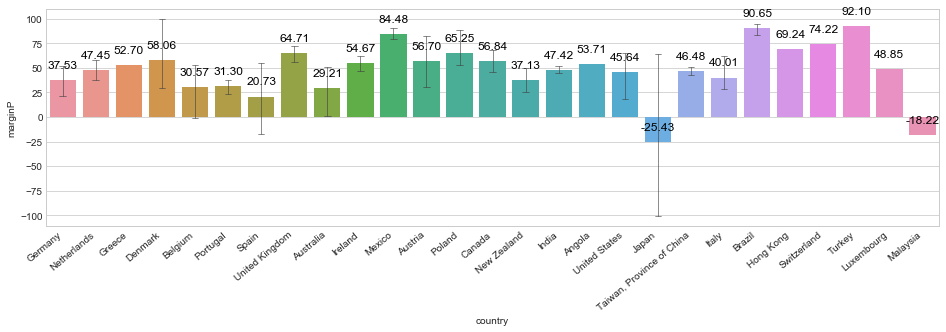

In [3]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

In [4]:
def converter(x):
    if x["business_name"] == "Toronto":
        return(c.convert(x["margin"], "CAD", "EUR"))
    if x["business_name"] == "Melbourne":
        return(c.convert(x["margin"], "AUD", "EUR"))
    if x["business_name"] == "London":
        return(c.convert(x["margin"], "GBP", "EUR"))
    else:
        return(x["margin"])

df_campaign=df_campaign.assign(**{"converted": df_campaign.apply(converter, axis=1)})

df_campaign["converted"]=df_campaign["converted"].round(2)

In [5]:
#total by country
df_campaign['total']=1
df_country=df_campaign.groupby(by=['country']).sum()
df_country["margin_%"]=(df_country["margin"]/df_country["revenue"])*100
df_country["margin_%"]=df_country["margin_%"].round(2)
df_country["country"]=df_country.index

### 1.2 Total Margin % per country

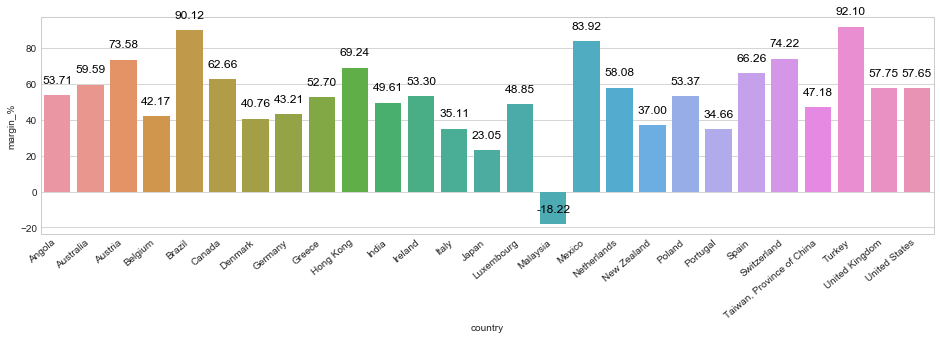

In [6]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="margin_%", data=df_country, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 1.3 Margin across countries in native currency

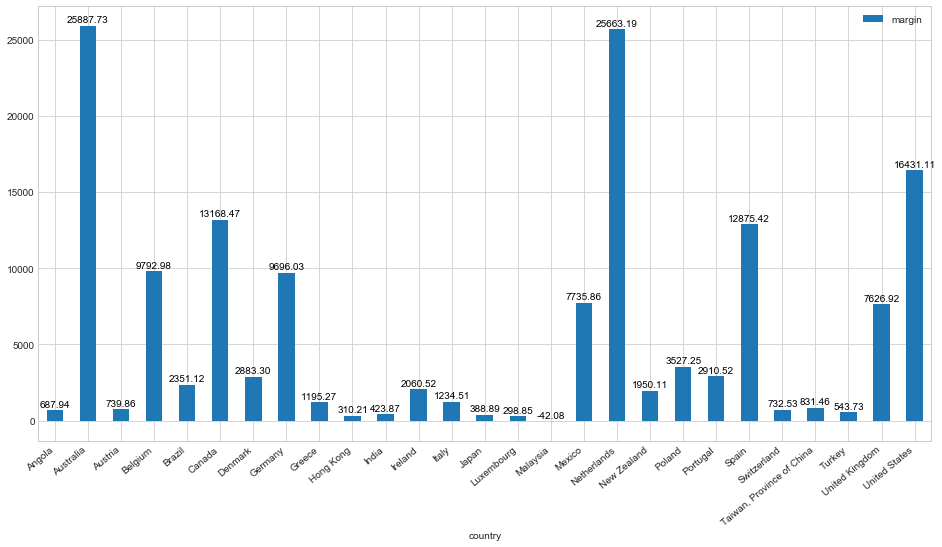

In [7]:
pa=df_country[["margin"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=10, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 1.4 Margins in Euro

#### *This currecy conversion should be updated relatively regularly. I have tested it a few times and it is very accurite with smaller amounts and within €5 (+/-) for larger amounts (e.g. 2606.53 CAD was converted to 1701.50 EUR, when it should be 1,696.17 EUR)*

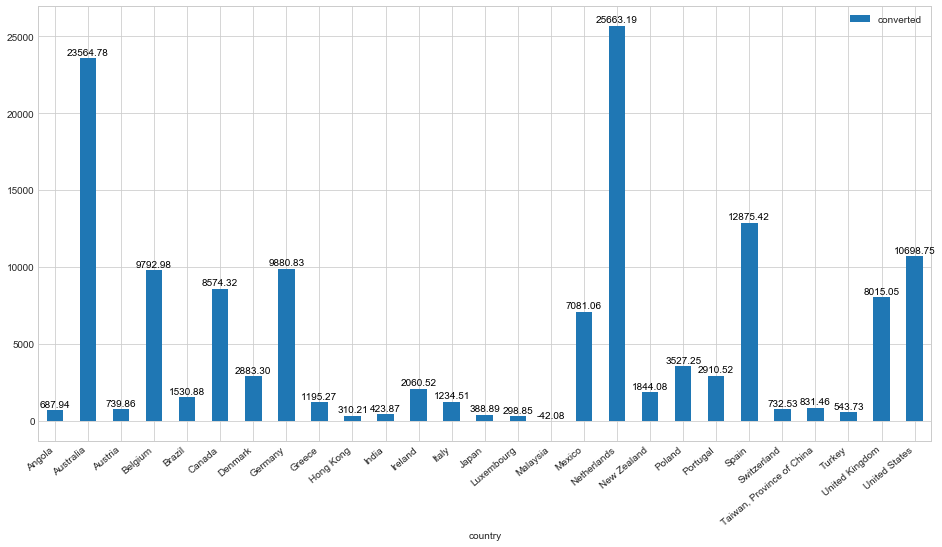

In [8]:
pa=df_country[["converted"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=10, color="black", xytext=(0, 6),
                 textcoords="offset points")

______

# 2. Performance per Marketer

### 2.1 Margin % of marketer's campaigns 

#### Onno

##### *Best*

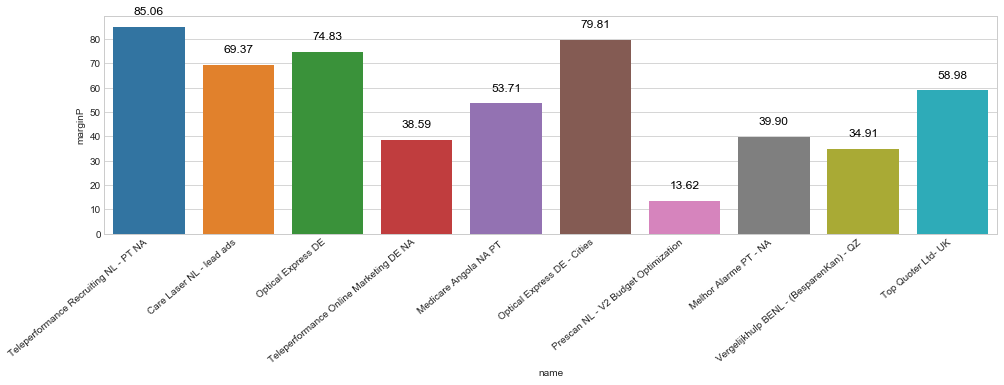

In [9]:
df_onno=df_campaign.loc[df_campaign["marketer_name"]=="Onno Bossen"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_onno.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### *Worst* 

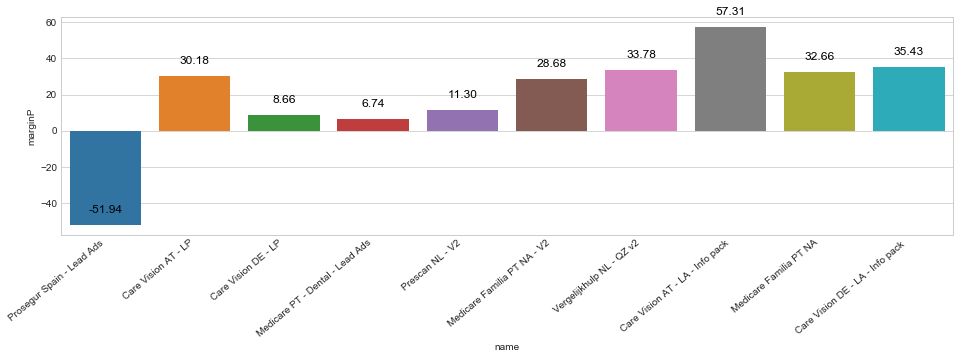

In [10]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_onno.loc[df_onno["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Marleen

##### *Best*

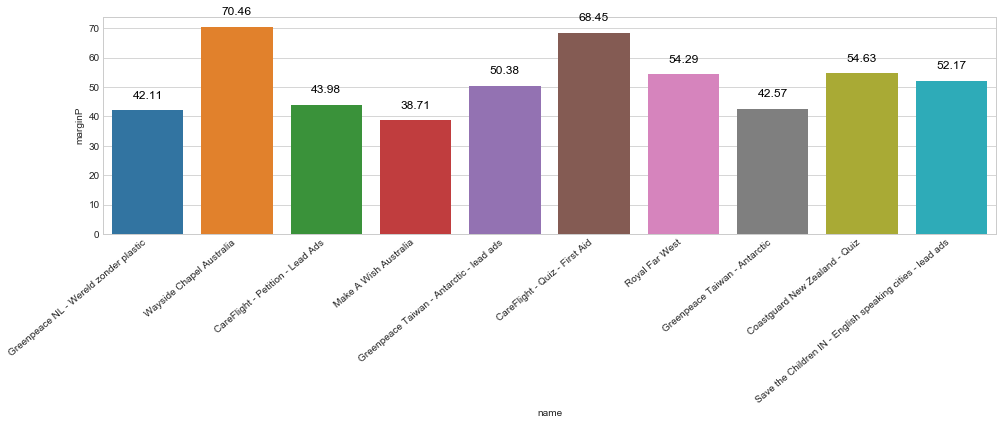

In [11]:
df_marleen=df_campaign.loc[df_campaign["marketer_name"]=="Marleen Blokker"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_marleen.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

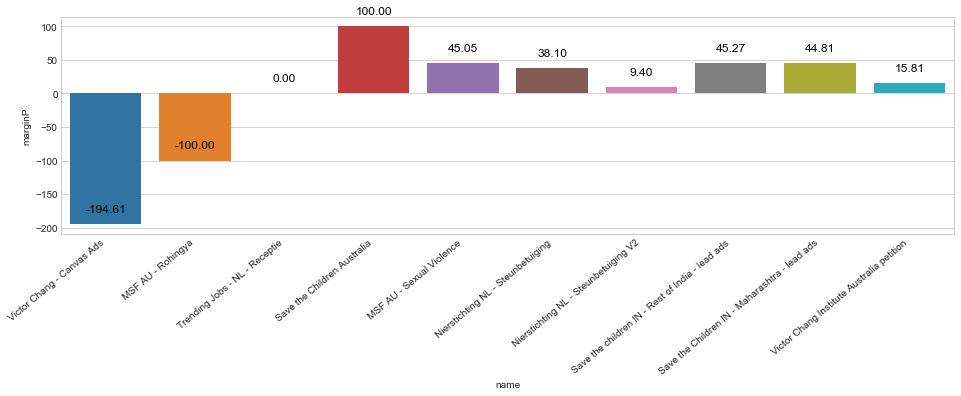

In [12]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_marleen.nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Robin

##### *Best*

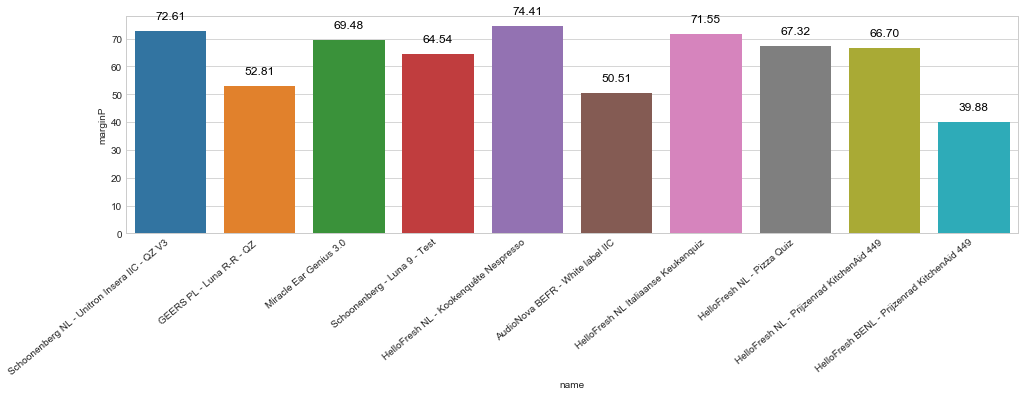

In [13]:
df_robin=df_campaign.loc[df_campaign["marketer_name"]=="Robin Ten Hove"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_robin.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

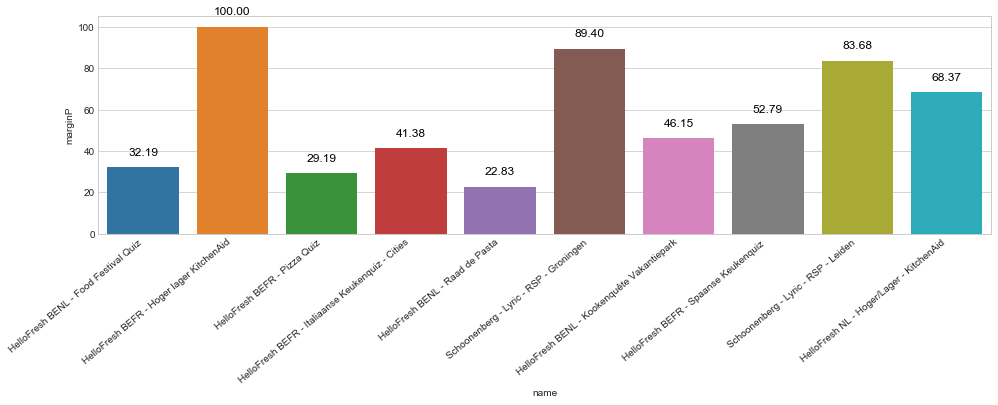

In [14]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_robin.loc[df_robin["leads"]>4].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Jeanine

##### *Best*

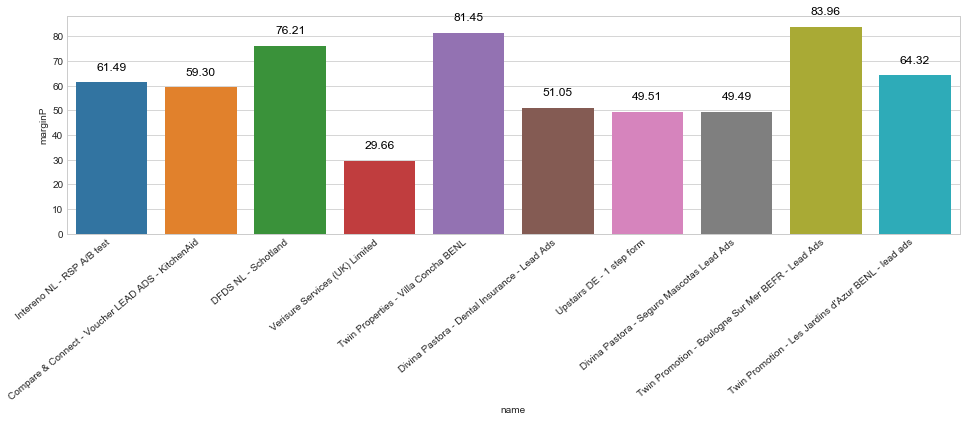

In [15]:
df_jeanine=df_campaign.loc[df_campaign["marketer_name"]=="Jeanine de Konnigh"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_jeanine.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

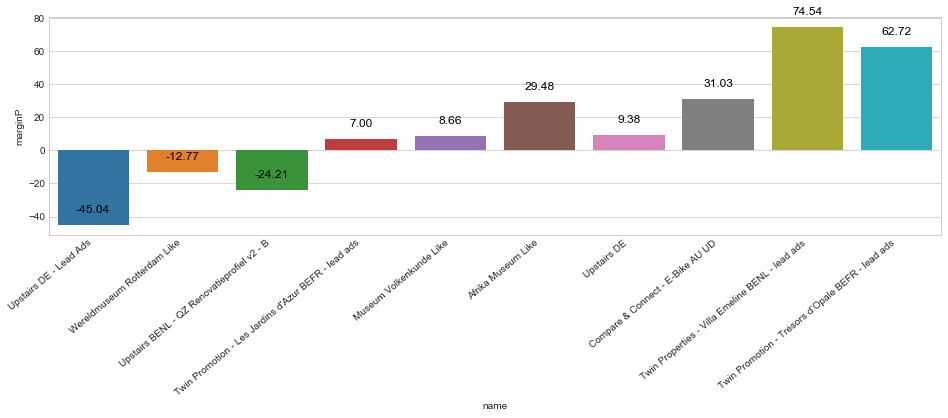

In [16]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_jeanine.loc[df_jeanine["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Daniela

##### *Best*

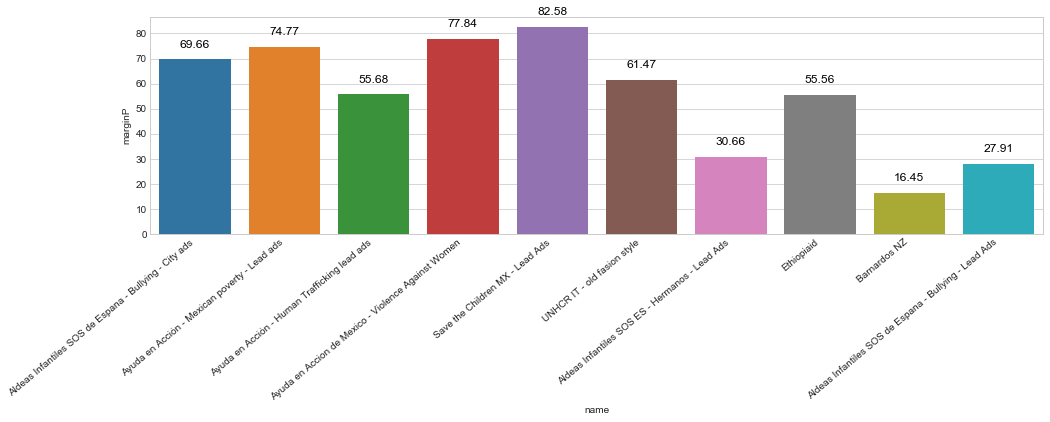

In [17]:
df_daniela=df_campaign.loc[df_campaign["marketer_name"]=="Daniela Jacobo Gallardo"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_daniela.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

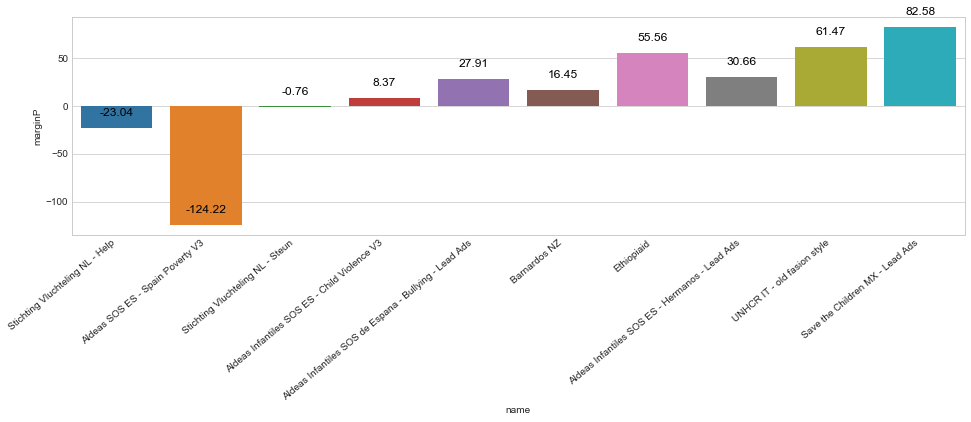

In [18]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_daniela.loc[df_daniela["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Rob

##### *Best*

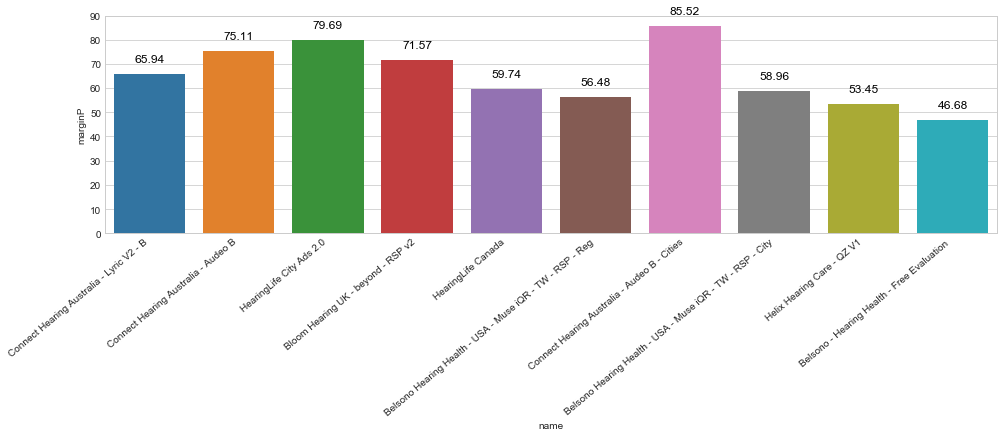

In [19]:
df_rob=df_campaign.loc[df_campaign["marketer_name"]=="Rob Ransome"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_rob.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

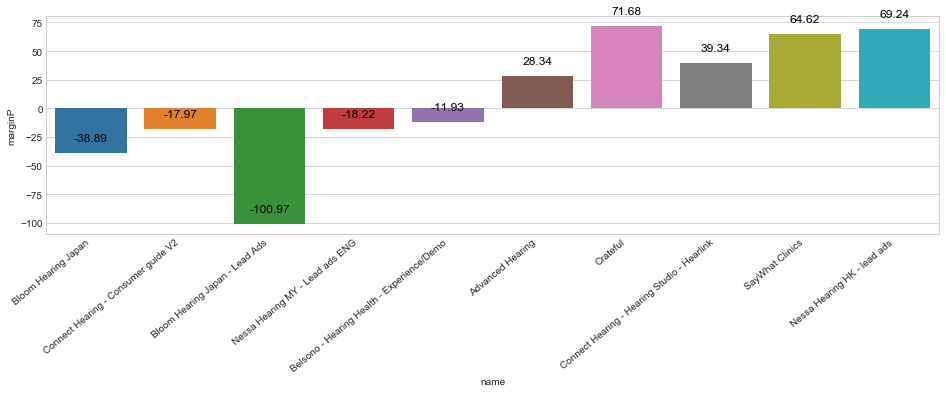

In [20]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_rob.loc[df_rob["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Sam

##### *Best*

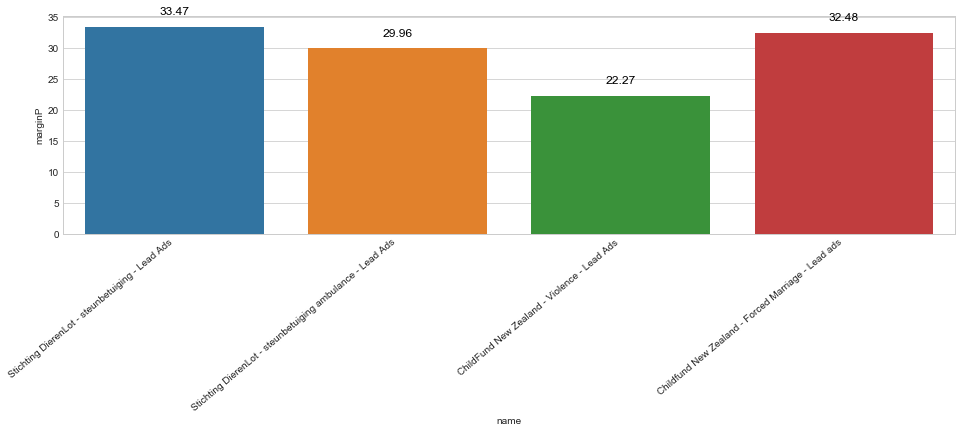

In [21]:
df_sam=df_campaign.loc[df_campaign["marketer_name"]=="Sam Drentje"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_sam.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

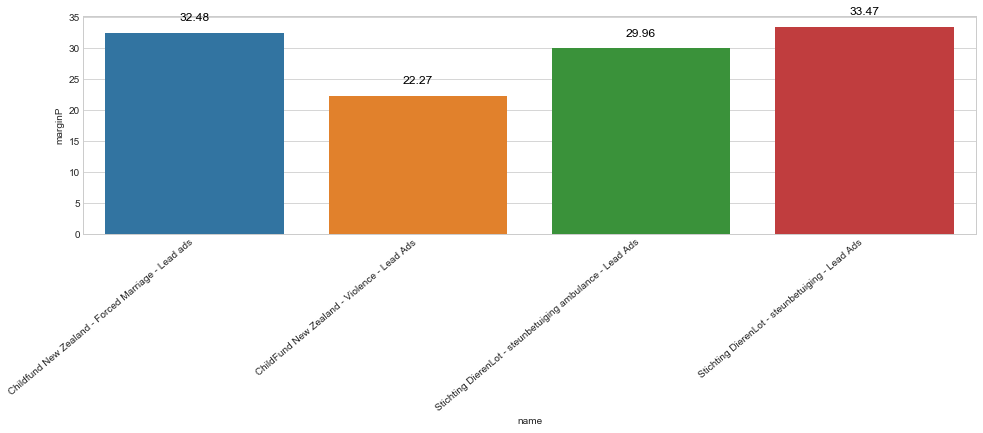

In [22]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_sam.loc[df_sam["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Theresa

##### *Best*

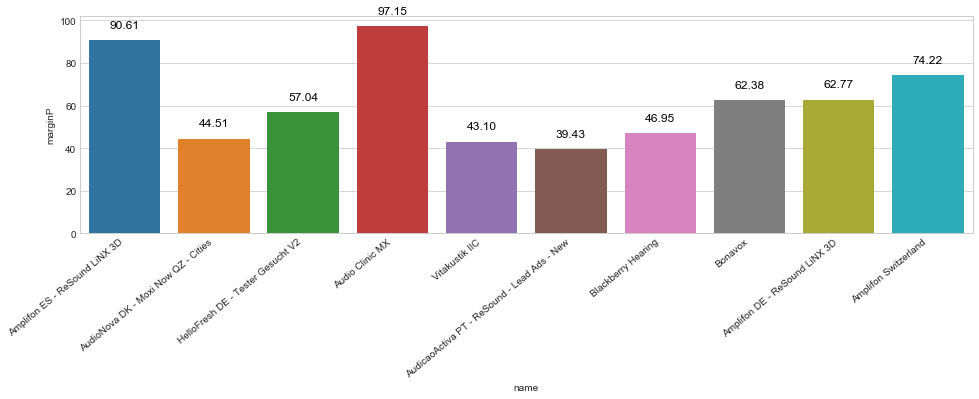

In [23]:
df_theresa=df_campaign.loc[df_campaign["marketer_name"]=="Theresa Majic"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_theresa.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

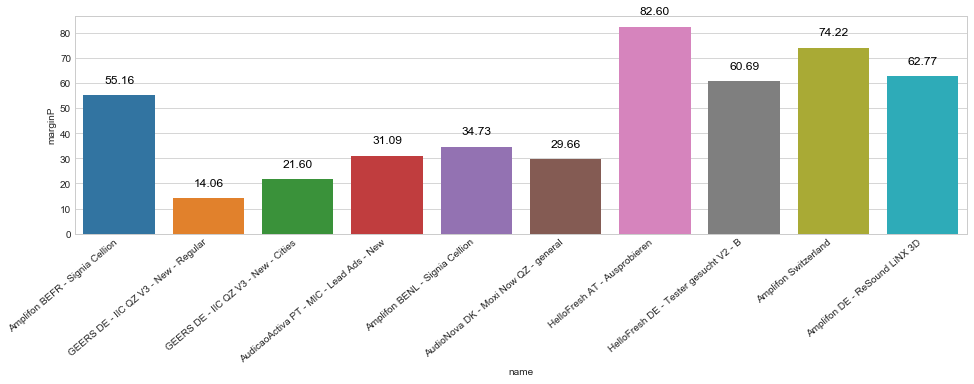

In [24]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_theresa.loc[df_theresa["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Mimmi

##### *Best*

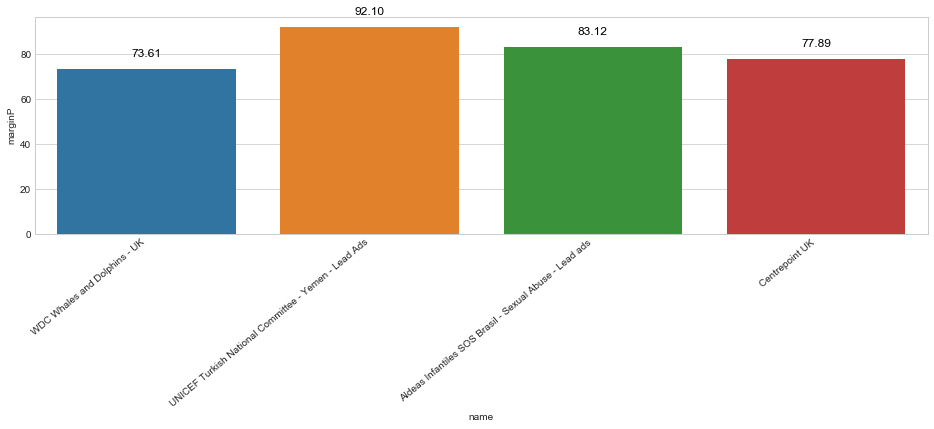

In [25]:
df_mimmi=df_campaign.loc[df_campaign["marketer_name"]=="Mimmi Ångström"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_mimmi.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

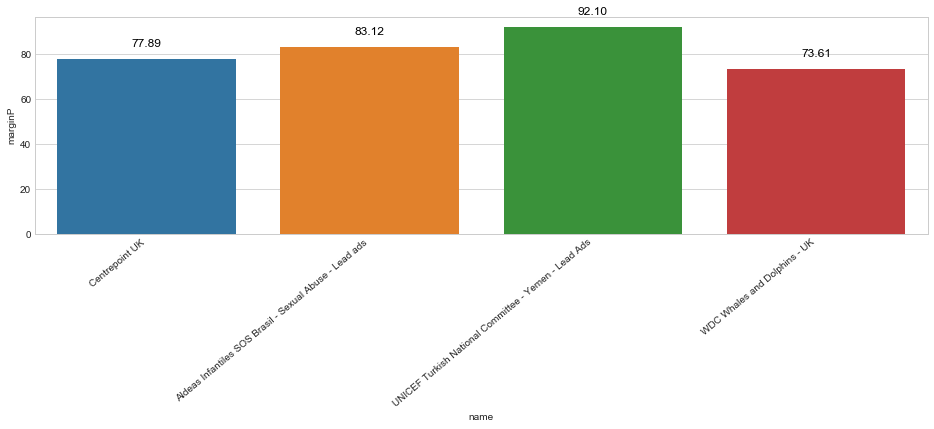

In [26]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_mimmi.loc[df_mimmi["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Abby

##### *Best*

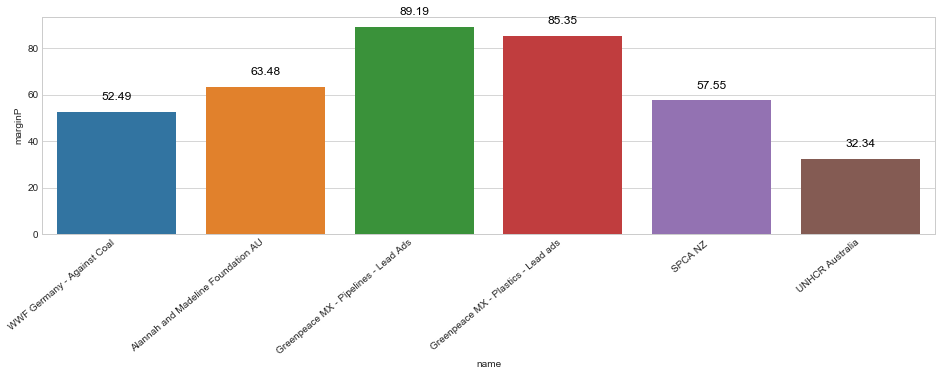

In [27]:
df_abby=df_campaign.loc[df_campaign["marketer_name"]=="Abby Listerman"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_abby.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

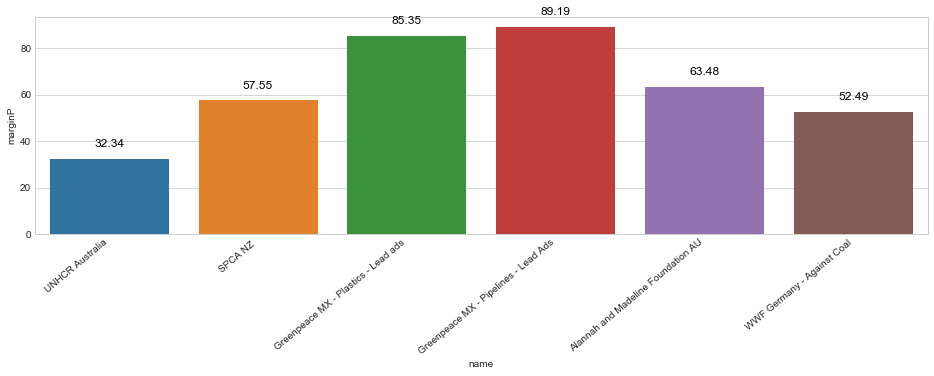

In [28]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_abby.loc[df_abby["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

In [29]:
#total by marketer
df_marketer=df_campaign.groupby(by=['marketer_name']).sum()

### 2.2 Margin made per Marketer (in Euro)

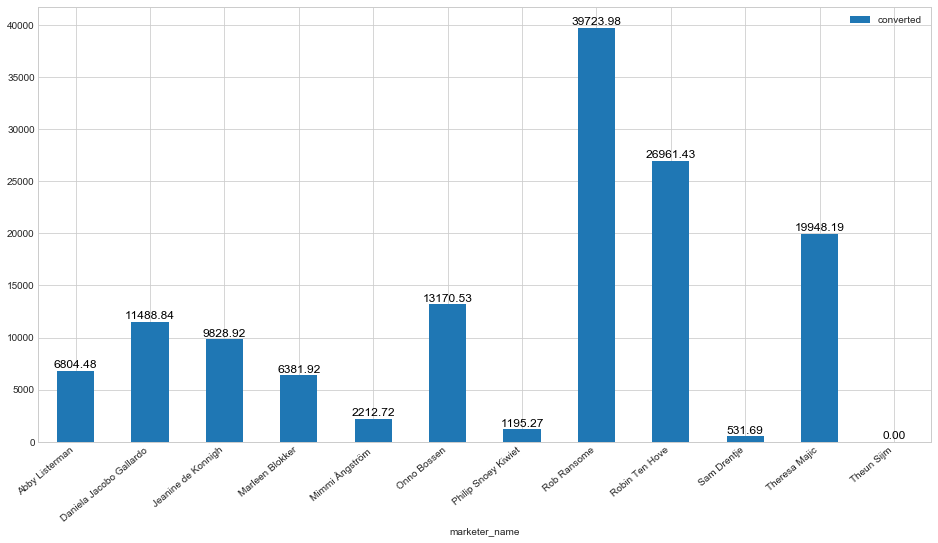

In [30]:
pa=df_marketer[["converted"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 2.3 Average margin per marketer

In [31]:
#creating new variable
df_marketer["average"]=df_marketer["converted"]/df_marketer["total"]

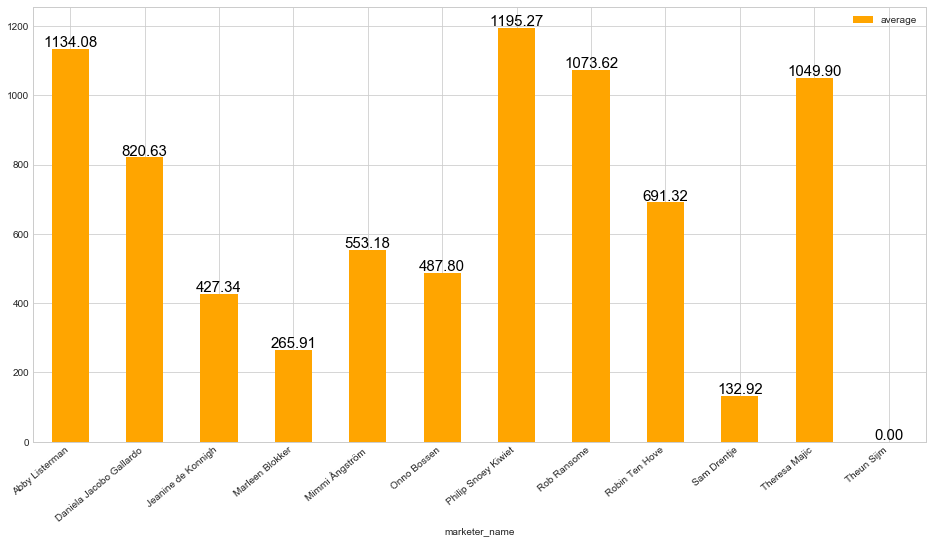

In [32]:
pa=df_marketer[["average"]].plot(kind="bar", figsize=(16,8), color="orange")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 2.4 Average margin % per marketer

In [33]:
#creating new variable
df_marketer["average_%"]=df_marketer["marginP"]/df_marketer["total"]

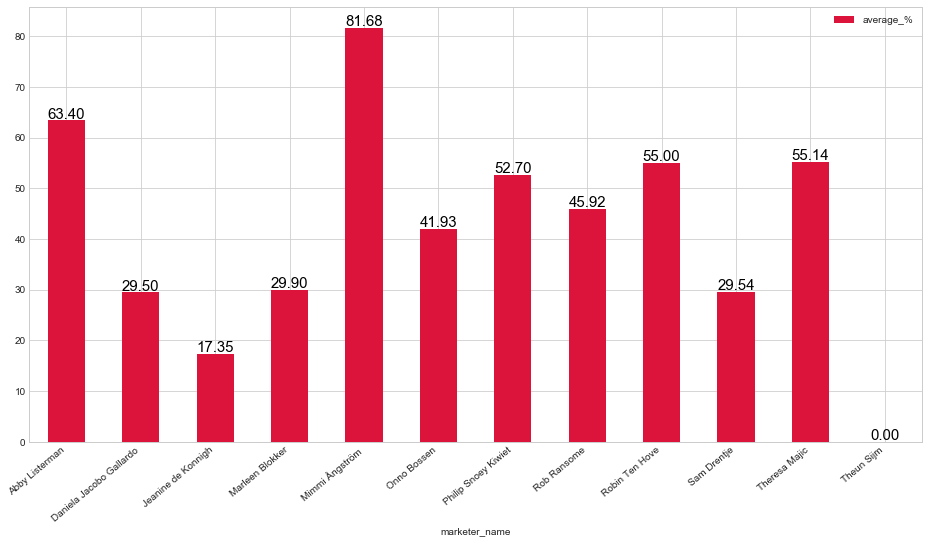

In [34]:
pa=df_marketer[["average_%"]].plot(kind="bar", figsize=(16,8), color="crimson")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

________

# 3. Performance per Vertical

In [35]:
def yoo(x):
    if x["marketer_name"]=="Onno Bossen" or x["marketer_name"]=="Jeanine de Konnigh":
        return("other?")
    if x["marketer_name"]=="Mimmi Ångström" or x["marketer_name"]=="Abby Listerman" or x["marketer_name"]=="Sam Drentje" or x["marketer_name"]=="Marleen Blokker" or x["marketer_name"]=="Daniela Jacobo Gallardo" or x["marketer_name"]=="Daphne Kok":
        return("NGOs")
    if x["marketer_name"]=="Theresa Majic" or x["marketer_name"]=="Philip Snoey Kiwiet" or x["marketer_name"]=="Robin Ten Hove" or x["marketer_name"]=="Rob Ransome":
        return("hearing aids")
df_campaign["vertical"] = df_campaign.apply(yoo, axis=1)

### 3.1 Average Margin % per vertical

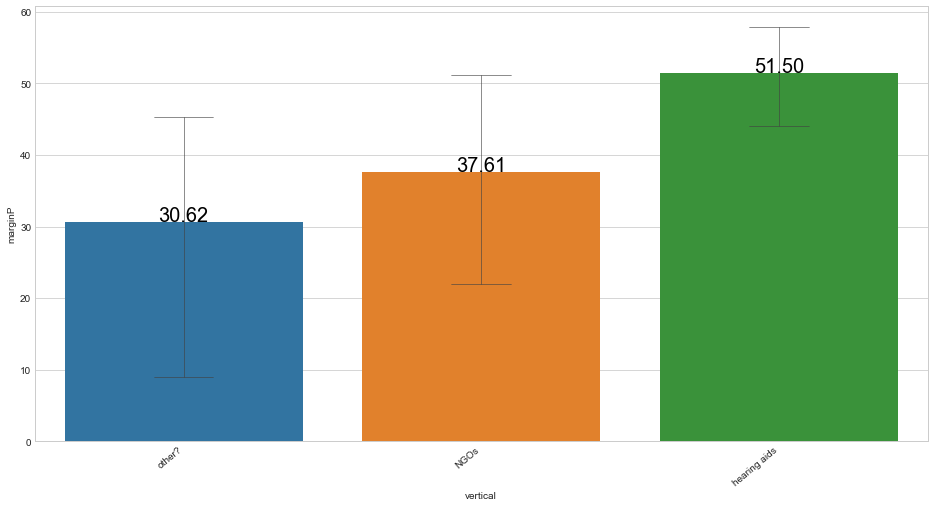

In [36]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="vertical", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

In [37]:
#total by vertical
df_vertical=df_campaign.groupby(by=['vertical']).sum()
df_vertical["margin_%"]=(df_vertical["margin"]/df_vertical["revenue"])*100
df_vertical["margin_%"]=df_vertical["margin_%"].round(2)
df_vertical["Vertical"]=df_vertical.index

### 3.2 Total Margin % per vertical

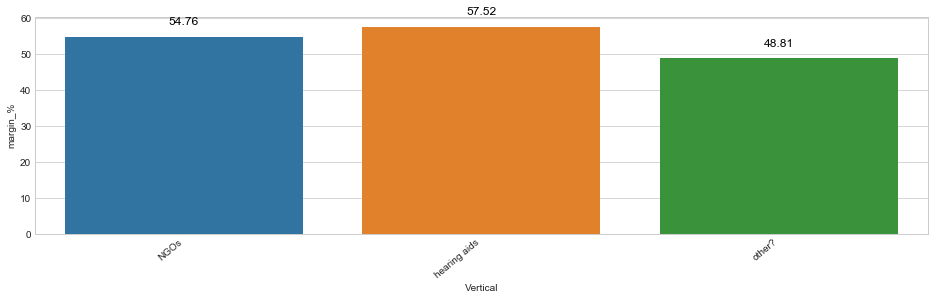

In [38]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="Vertical", y="margin_%", data=df_vertical, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 3.3 Total Margin per vertical

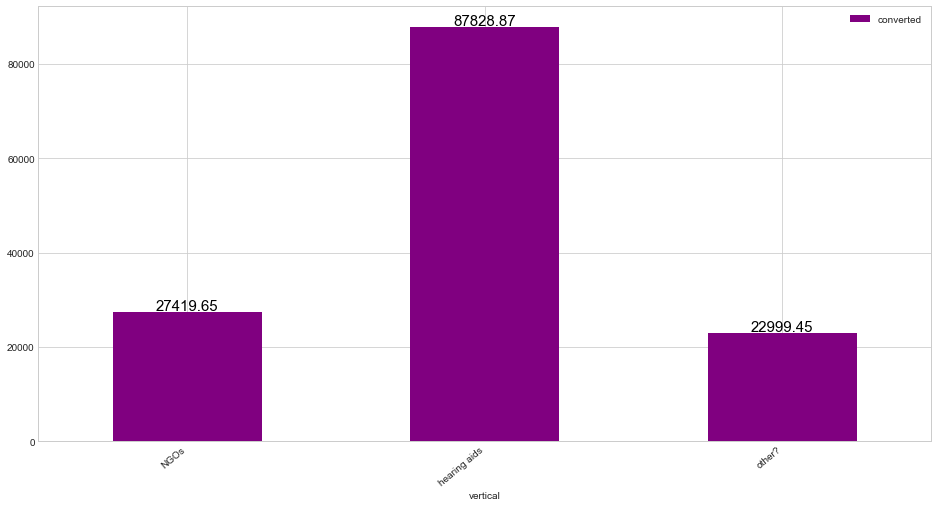

In [39]:
pa=df_vertical[["converted"]].plot(kind="bar", figsize=(16,8), color="purple")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

_______

# 4. Performance per Business

### 4.1 Average Margin % per business

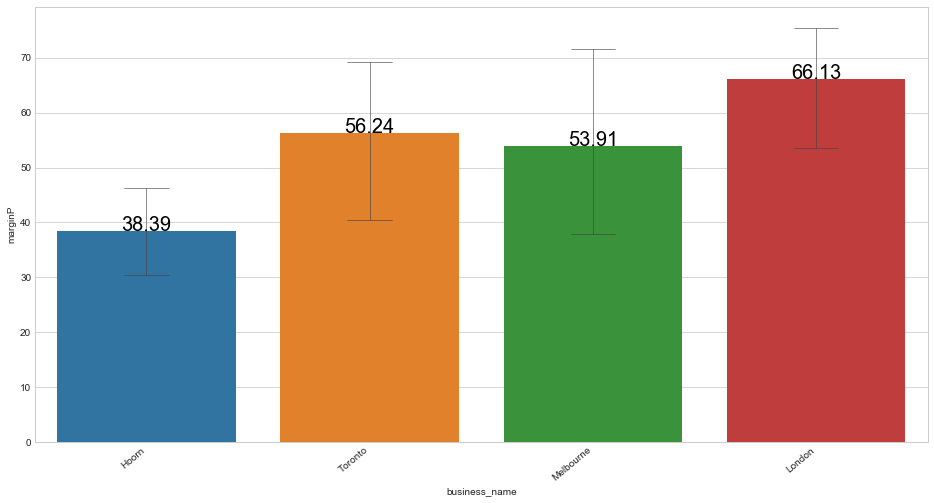

In [40]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="business_name", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

In [41]:
#total by business
df_business=df_campaign.groupby(by=['business_name']).sum()
df_business["margin_%"]=(df_business["margin"]/df_business["revenue"])*100
df_business["margin_%"]=df_business["margin_%"].round(2)
df_business["Business"]=df_business.index

### 4.2 Total Margin % per business

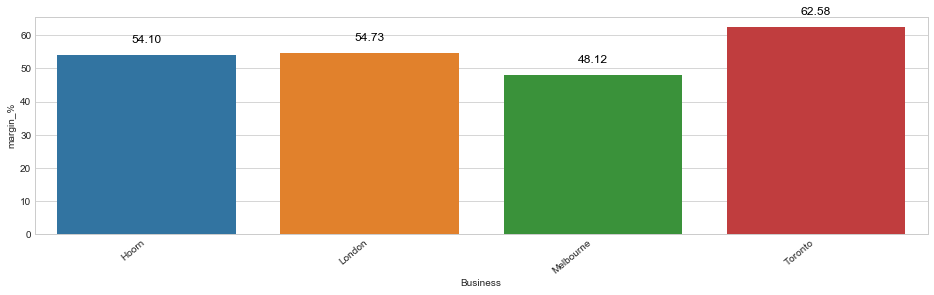

In [42]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="Business", y="margin_%", data=df_business, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 4.3 Margin per Business (in Euro)

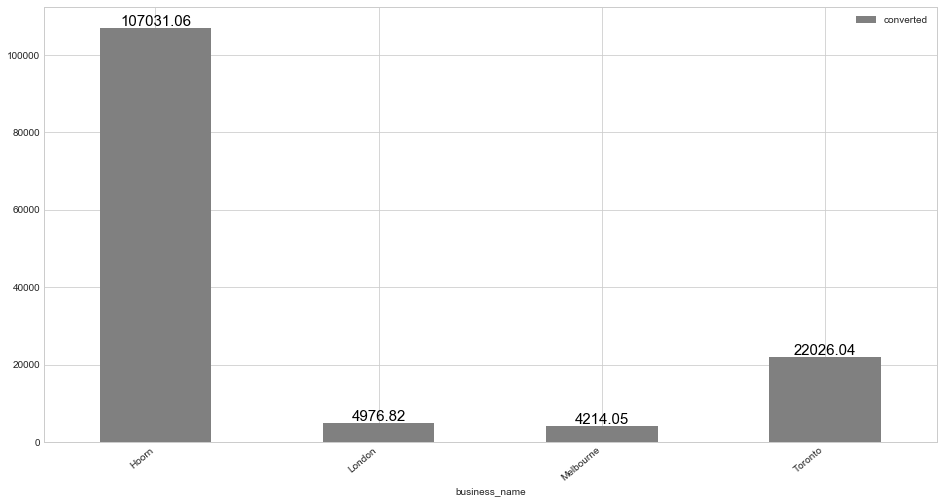

In [43]:
pa=df_business[["converted"]].plot(kind="bar", figsize=(16,8), color="grey")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

___________

# 5. Performance per Day of the Week

CPC, CTR, CPM, CR and CPA are displayed as the average per day

In [44]:
#importing multiple files using glob
#getting bert data
sheetnames=glob.glob("28__*.xlsx")
list_of_dfs = [pd.read_excel(sheet) for sheet in sheetnames]
for dataframe, sheet in zip(list_of_dfs, sheetnames):
    dataframe["day_num"] = sheet
df_daily = pd.concat(list_of_dfs, ignore_index=True) 

In [45]:
### Cleaning

#creating day of the week variable
df_daily["day_num"]=df_daily["day_num"].str.split("_").str[2]
def doo(x):
    if x["day_num"] == "1.xlsx":
        return("monday")
    if x["day_num"] == "2.xlsx":
        return("tuesday")
    if x["day_num"] == "3.xlsx":
        return("wednesday")
    if x["day_num"] == "4.xlsx":
        return("thursday")
    if x["day_num"] == "5.xlsx":
        return("friday")
    if x["day_num"] == "6.xlsx":
        return("saturday")
    else:
        return("sunday")
df_daily["day"] = df_daily.apply(doo, axis=1)

#dropping unused columns
df_daily.drop(columns=["id","status","ad_set_manager_id","client_id","ap_campaign_id","ad_set_campaign_group_id",
                      "notification_stop_spend","notification_stop_spend_threshold","margin_percentage",
                      "facebook_business_id","url","contract_range","salesforce_oppurtunity_id"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_daily["marginP"] = df_daily.apply(woo, axis=1)
df_daily["marginP"] = df_daily["marginP"].round(2)

#2. COUNTRY NAMES
df_daily["country"]=df_daily["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_daily["country"] = df_daily["country"].apply(get_country_code)
df_daily.drop(columns=["iso_code"], inplace=True)

df_daily.drop(columns=["day_num"], inplace=True)

order=["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]

### 5.1 Average Margin % per day of the Week

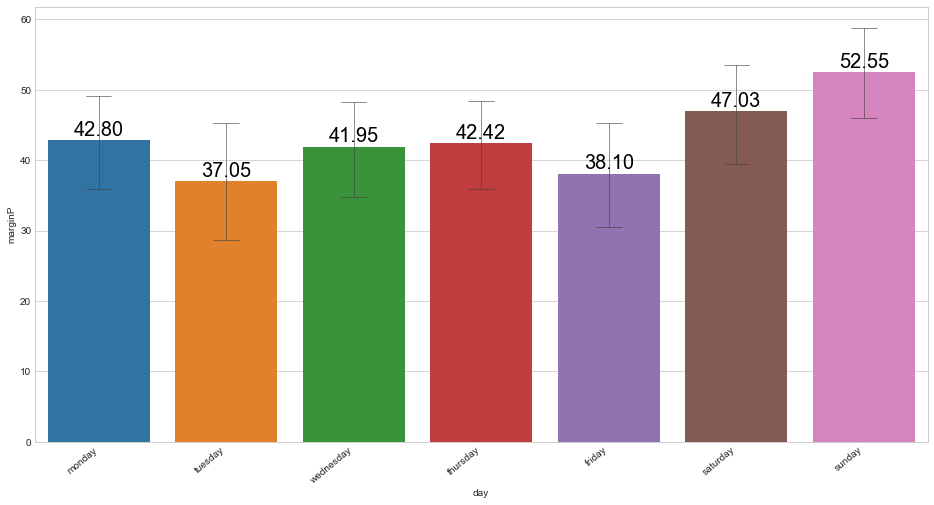

In [46]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="day", y="marginP", data=df_daily, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

In [47]:
df_daily=df_daily.assign(**{"converted": df_daily.apply(converter, axis=1)})

df_daily["converted"]=df_daily["converted"].round(2)

In [48]:
#total by vertical
df_daily_group=df_daily.groupby(by=["day"]).sum()
df_daily_group["margin_%"]=(df_daily_group["margin"]/df_daily_group["revenue"])*100
df_daily_group["margin_%"]=df_daily_group["margin_%"].round(2)
df_daily_group["Day"]=df_daily_group.index

### 5.2 Total Margin % per day

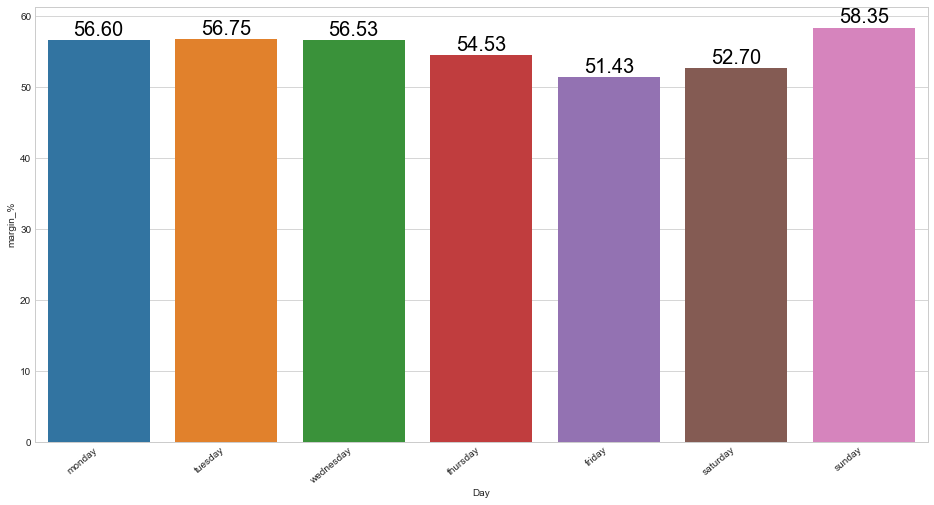

In [49]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="Day", y="margin_%", data=df_daily_group, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

### 5.3 Total Margin

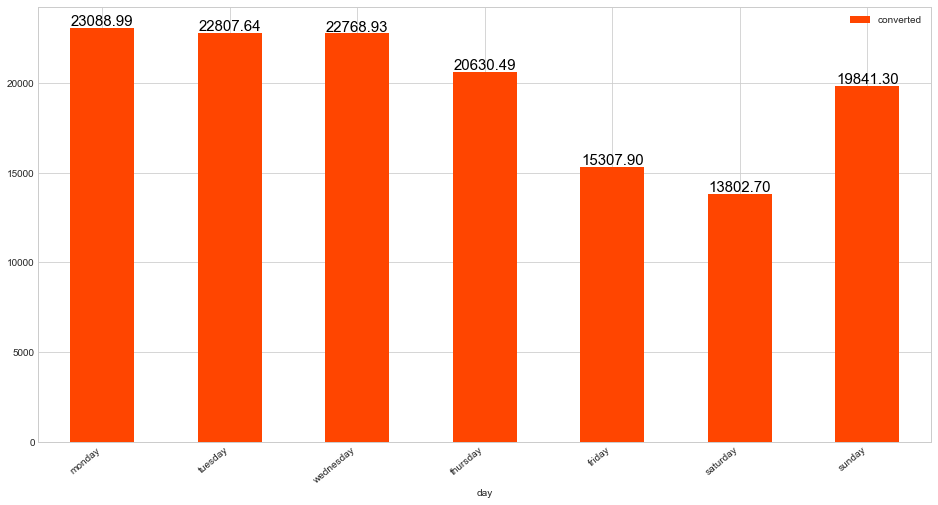

In [50]:
pa=df_daily_group[["converted"]].loc[order].plot(kind="bar", figsize=(16,8), color="orangered")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 5.4 CPA

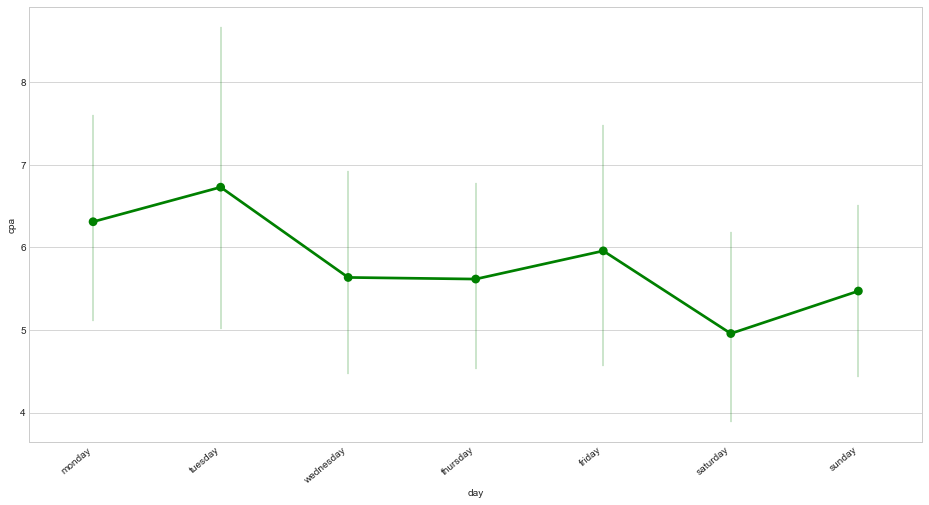

In [51]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpa", data=df_daily, order=order, color="g", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.5 CPC

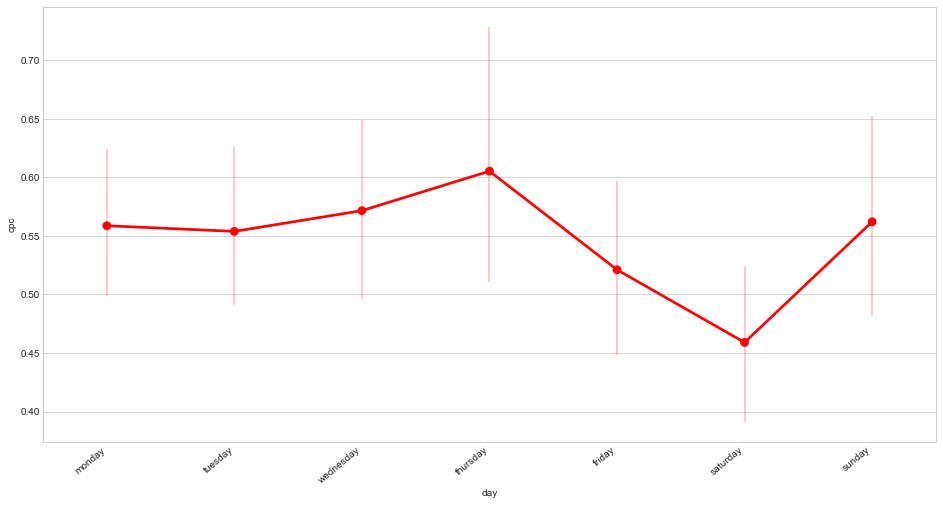

In [52]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpc", data=df_daily, order=order, color="r", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.6 CPM

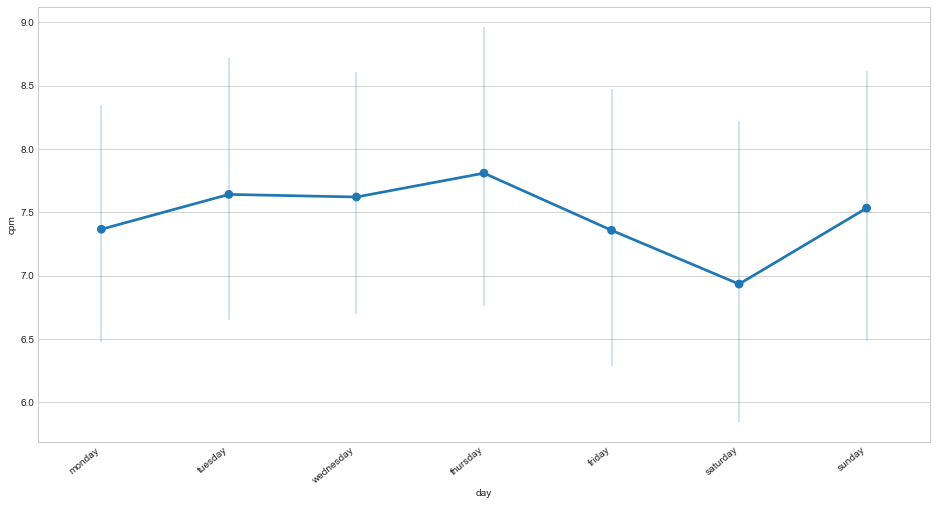

In [53]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpm", data=df_daily, order=order, dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.7 CR

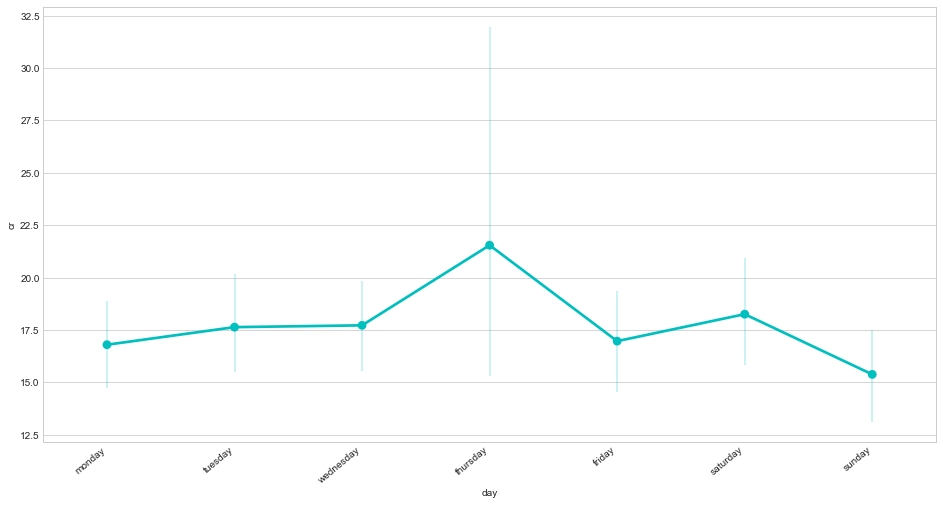

In [54]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.8 CTR

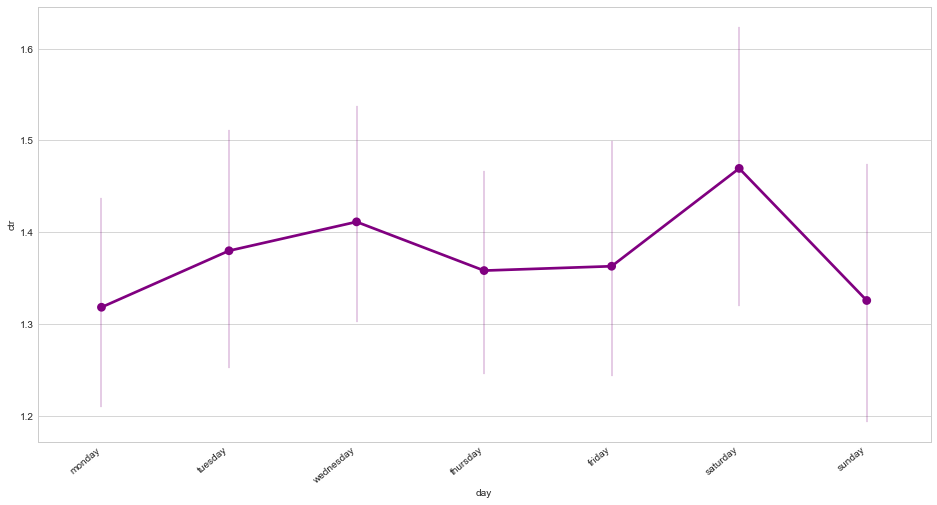

In [55]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="ctr", data=df_daily, order=order, color="purple", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

_______

# 6. Top performing new ads

In [56]:
##### Cleaning

df_raw=pd.read_excel("28_newads.xlsx")

#subsetting data
df_newads=df_raw.loc[df_raw["insert_time"]>=datetime(2018,7,9)]

#dropping columns
df_newads.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                       "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                       "short_url","ad_url_domain_id"], inplace=True)




The table below shows new ads that had a margin % above 50%. They are displayed in descending order from highest margin to lowest (this will filter out ads with 100% margins that made very little money). 



In [57]:
df_newads.loc[df_newads['marginP']>=50].nlargest(10,'margin').drop(columns=["name","relevance_score","insert_time",
                                                                            "revenue_type","frequency"])

,tag,campaign_name,marketer_name,campaign_manager_name,account_manager_name,label_name,budget,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,update_time,currency,marginP,views,clicks
1593,SB000000001163246,Helix Hearing Care - QZ V1,Rob Ransome,Daniela Salom Cardenas,Sander Janssen,none,40.0,32,963.20,263.95,699.25,1.9,1.0,18.6,11.9,8.2,2018-07-09 15:00:04,CAD,7.259655e+13,14226,268
1836,SB000000001164446,Audio Clinic MX,Theresa Majic,Daniela Salom Cardenas,Noel Prieto,none,15.0,36,662.40,14.49,647.91,4.1,0.1,4.0,24.2,0.4,2018-07-16 08:01:36,CAD,9.781250e+05,3627,149
1835,SB000000001164440,Audio Clinic MX,Theresa Majic,Daniela Salom Cardenas,Noel Prieto,none,15.0,33,607.20,15.03,592.17,3.4,0.1,4.2,27.5,0.5,2018-07-16 08:01:36,CAD,9.752470e+13,3544,120
1594,SB000000001163249,Helix Hearing Care - QZ V1,Rob Ransome,Daniela Salom Cardenas,Sander Janssen,none,40.0,26,782.60,264.27,518.33,2.0,1.0,20.7,10.3,10.2,2018-07-09 15:00:04,CAD,6.623179e+12,12792,252
1673,SB000000001164239,DFDS NL - Schotland,Jeanine de Konnigh,Jordy Schreuder,Sander Janssen,none,20.0,394,586.09,88.62,497.47,3.3,0.1,4.1,54.9,0.2,2018-07-11 15:15:30,EUR,8.487946e+13,21795,718
1595,SB000000001163252,Helix Hearing Care - QZ V1,Rob Ransome,Daniela Salom Cardenas,Sander Janssen,none,40.0,25,752.50,263.90,488.60,1.4,1.1,16.1,10.6,10.6,2018-07-09 15:00:03,CAD,6.493023e+12,16360,235
1476,SB000000001163471,AudicaoActiva PT - MIC - Lead Ads - New,Theresa Majic,Aedan Toal,Othman Namri,none,40.0,35,582.75,248.21,334.54,1.1,0.4,3.9,4.9,7.1,2018-07-09 16:30:16,EUR,5.740712e+13,62938,709
1670,SB000000001164221,Greenpeace Taiwan - Antarctic - lead ads,Marleen Blokker,Jordy Schreuder,Othman Namri,none,30.0,214,385.20,55.68,329.52,1.6,0.1,1.6,38.8,0.3,2018-07-16 09:17:11,EUR,8.554517e+13,35021,551
1838,SB000000001164455,Audio Clinic MX,Theresa Majic,Daniela Salom Cardenas,Noel Prieto,none,15.0,18,331.20,12.46,318.74,2.1,0.2,3.8,25.7,0.7,2018-07-16 08:01:38,CAD,9.623792e+13,3280,70
1837,SB000000001164452,Audio Clinic MX,Theresa Majic,Daniela Salom Cardenas,Noel Prieto,none,15.0,18,331.20,13.13,318.07,2.2,0.2,5.0,31.6,0.7,2018-07-16 08:01:37,CAD,9.603563e+13,2605,57


.


e.g. this shows the top 10 margin (percentage) ads that had margins of over €150, ordered from highest conversion rate to lowest conversion rate.


In [58]:
df_newads.loc[df_newads['margin']>=150].nlargest(10,'marginP').sort_values(by='cr', ascending=False).drop(columns=["name","relevance_score","insert_time",
                                                                            "revenue_type","frequency"])

,tag,campaign_name,marketer_name,campaign_manager_name,account_manager_name,label_name,budget,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,update_time,currency,marginP,views,clicks
1673,SB000000001164239,DFDS NL - Schotland,Jeanine de Konnigh,Jordy Schreuder,Sander Janssen,none,20.0,394,586.09,88.62,497.47,3.3,0.1,4.1,54.9,0.2,2018-07-11 15:15:30,EUR,8.487946e+13,21795,718
1847,SB000000001164959,HearingLife City Ads 2.0,Rob Ransome,Daniela Salom Cardenas,Leigh Gough,none,3.0,10,198.00,8.14,189.86,3.5,0.4,13.4,47.6,0.8,2018-07-16 07:01:22,CAD,9.588889e+13,607,21
1666,SB000000001164149,Connect Hearing Australia - Audeo B - Cities,Rob Ransome,Marisa Jimenez,Sander Janssen,none,6.0,8,176.00,10.99,165.01,2.4,0.6,14.1,42.1,1.4,2018-07-15 17:31:50,EUR,9.375568e+13,782,19
1670,SB000000001164221,Greenpeace Taiwan - Antarctic - lead ads,Marleen Blokker,Jordy Schreuder,Othman Namri,none,30.0,214,385.20,55.68,329.52,1.6,0.1,1.6,38.8,0.3,2018-07-16 09:17:11,EUR,8.554517e+13,35021,551
1837,SB000000001164452,Audio Clinic MX,Theresa Majic,Daniela Salom Cardenas,Noel Prieto,none,15.0,18,331.20,13.13,318.07,2.2,0.2,5.0,31.6,0.7,2018-07-16 08:01:37,CAD,9.603563e+13,2605,57
1659,SB000000001164068,Aldeas Infantiles SOS de Espana - Bullying - C...,Daniela Jacobo Gallardo,Theun Sijm,Maider Sánchez Elizondo,none,NaN,88,201.97,41.41,160.56,2.7,0.1,3.5,27.8,0.5,2018-07-16 01:02:52,EUR,7.949695e+13,11848,317
1835,SB000000001164440,Audio Clinic MX,Theresa Majic,Daniela Salom Cardenas,Noel Prieto,none,15.0,33,607.20,15.03,592.17,3.4,0.1,4.2,27.5,0.5,2018-07-16 08:01:36,CAD,9.752470e+13,3544,120
1838,SB000000001164455,Audio Clinic MX,Theresa Majic,Daniela Salom Cardenas,Noel Prieto,none,15.0,18,331.20,12.46,318.74,2.1,0.2,3.8,25.7,0.7,2018-07-16 08:01:38,CAD,9.623792e+13,3280,70
1788,SB000000001165313,Schoonenberg - Lyric - RSP - Leiden,Robin Ten Hove,Marisa Jimenez,Bart Kramer,none,1.0,12,216.00,35.26,180.74,2.1,0.4,8.3,13.3,2.9,2018-07-16 07:45:41,EUR,8.367593e+13,4224,90
1750,SB000000001165037,Teleperformance Recruiting NL - PT NA,Onno Bossen,Sjoerd Knol,Bart Kramer,none,25.0,12,216.00,41.49,174.51,1.1,0.3,3.7,10.0,3.5,2018-07-16 07:00:18,EUR,8.079167e+13,11073,120


______________

# 7. Campaigns that are dropping in margin from 45% + to below 45%

In [59]:
#importing new dataset
df_comp_raw=pd.read_excel("27_newads.xlsx")


####FOR WEEK BEFORE DF####


#dropping columns
df_comp_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                          "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                          "short_url","ad_url_domain_id"], inplace=True)


#1. FIX MARGIN_P
df_comp_raw["marginP"] = df_comp_raw.apply(woo, axis=1)
df_comp_raw["marginP"] = df_comp_raw["marginP"].round(2)



####FOR FULL RAW WEEK#####


#dropping columns
df_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                     "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                     "short_url","ad_url_domain_id"], inplace=True)


#1. FIX MARGIN_P
df_raw["marginP"] = df_raw.apply(woo, axis=1)
df_raw["marginP"] = df_raw["marginP"].round(2)


#####SLIMMING COMB DATA DOWN TO ONLY INCLUDE MARGINS ABOVE 45%###########
df_comp=df_comp_raw.loc[df_comp_raw["marginP"]>=45]

####COMBING DATA SETS########
df_452=df_comp.merge(df_raw, how ="inner", on = ["tag"])

df_45=df_452.loc[df_452["marginP_y"]<45]

The number of ads that dropped below 45%: 

In [60]:
len(df_45)

244

In [61]:
#making difference variable
df_45["diff_mP"]=df_45["marginP_x"]-(df_45["marginP_y"])
df_45["diff_m"]=df_45["margin_x"]-(df_45["margin_y"])

In [62]:
#ordering df for simple comparisons
df_45vis = df_45[["tag","campaign_name_x","name_x","diff_mP","diff_m","marginP_x","marginP_y","margin_x","margin_y","ctr_x",
                  "ctr_y","cpm_x","cpm_y","cr_x","cr_y","cpa_x","cpa_y"]]

These are the 10 ads that lost the largest amount of money between the two weeks (i.e. Week 27 and Week 28). 
Here we can compare the other variables a bit easier as well.

_x = week 27

_y = week 28

diff_mP = Difference in Margin % between Week 28 and Week 27 .  
diff_m = Difference in Margin between Week 28 and Week 27 .   

In [63]:
df_45vis.nlargest(10,"diff_m")#.sort_values(by='diff_m', ascending=False)

,tag,campaign_name_x,name_x,diff_mP,diff_m,marginP_x,marginP_y,margin_x,margin_y,ctr_x,ctr_y,cpm_x,cpm_y,cr_x,cr_y,cpa_x,cpa_y
595,SB000000001159889,Prescan NL - V2 Budget Optimization,T F4 CL Oct1 F M/F 20+ ALL,81.18,937.93,65.29,-15.89,842.26,-95.67,0.8,0.7,5.6,3.9,4.6,1.1,14.9,49.8
596,SB000000001159895,Prescan NL - V2 Budget Optimization,T F4 CL Oct1 C M/F 20+ ALL,56.28,802.40,57.17,0.89,811.22,8.82,1.0,0.8,5.9,5.5,3.3,1.7,18.4,42.6
500,SB000000001155953,Optical Express UK,T20 I iStock May1 C M/F 18+ ALL,51.89,613.17,76.29,24.40,636.59,23.42,0.6,0.3,3.8,3.8,20.5,12.3,3.1,9.1
304,SB000000001145768,Nessa Hearing HK - lead ads,T2 May I FEB E M/V 50+ ALL,41.67,540.79,80.35,38.68,562.45,21.66,1.7,1.1,11.4,9.9,11.9,5.1,5.5,17.2
324,SB000000001141280,Helix Hearing Care - QZ V1,T6. 2 Hybrid I B M/V 50+ ALL,32.43,516.53,63.43,31.00,973.77,457.24,1.0,1.1,15.0,22.2,13.2,10.1,11.0,20.8
791,SB000000001162871,Belsono Hearing Health - USA - Muse iQR - TW -...,T4 City SB DESIGN A M/F 50+ ALL - Rochester - NY,40.87,430.44,81.70,40.83,614.78,184.34,2.5,2.2,21.5,23.9,15.8,6.0,5.5,17.8
340,SB000000001141685,Barnardos NZ,T1 I Client Deon M/V 30+ ALL,32.13,414.78,48.27,16.14,522.81,108.03,2.7,2.0,9.1,10.3,14.4,13.6,2.3,3.9
263,SB000000001141046,Prescan NL - V2,TF I DEC L MV35+ M LAL 5% CV,31.22,413.55,56.73,25.51,512.29,98.74,1.2,1.1,8.8,9.1,4.0,2.6,18.6,32.0
366,SB000000001150664,Connect Hearing - Hearing Studio - Lyric,T1 V Lyric NOV VID 01 m/v 45+ D/M,44.06,385.45,69.33,25.27,396.57,11.12,1.6,1.0,16.4,14.6,15.0,9.1,6.7,16.4
492,SB000000001154201,Connect Hearing CA,T3 updated V SB JUNE AA M/F 50+ ALL,10.03,328.33,51.68,41.65,538.26,209.93,1.1,1.0,16.0,17.6,9.0,8.7,16.2,19.6


In [64]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>

______